In [108]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(crayon)
}))

# Definitions etc

In [109]:
set.seed(1234)
options(digits=2)

In [110]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    prj_path = "/home/vsevim/prj/1012-ckd/S1/"
    data_subdir = "/analysis/primary/cellranger/Screen1_66guides_L1/outs/"
    seurat_obj_path = "/home/vsevim/prj/1012-ckd/S1//analysis/secondary/Lib_1//seurat_objects/"
    seurat_obj_fname = "Screen1_66guides_Lib_1.h5seurat"
    library_name = "Lib_1"
    save_seurat_h5 = "NO"
}

In [162]:
data_path <- paste0(prj_path, data_subdir)
mx_path   <- paste0(data_path, "/filtered_feature_bc_matrix/")
h5_path   <- paste0(data_path, "/filtered_feature_bc_matrix.h5")
umi_thresholds_path <- paste0(data_path, "/crispr_analysis/protospacer_umi_thresholds.csv")
ps_calls_path <- paste0(data_path, "/crispr_analysis/protospacer_calls_per_cell.csv")
save_h5_file <- paste0(seurat_obj_path, seurat_obj_fname, ".h5seurat")

In [112]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

In [156]:
data_path

[1] "/home/vsevim/prj/1012-ckd/S1//analysis/primary/cellranger/Screen1_66guides_L1/outs/"

### Load cell-cycle data

In [113]:
# A list of cell cycle markers, from Tirosh et al, 2015, is loaded with Seurat.  We can
# segregate this list into markers of G2/M phase and markers of S phase
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes


### Load 10x data

In [114]:
inputdata   <- Read10X_h5(h5_path)

Genome matrix has multiple modalities, returning a list of matrices for this genome



In [115]:
# extract RNA and sgRNA data
rna_counts   <- inputdata$`Gene Expression`
sgrna_counts <- inputdata$`CRISPR Guide Capture`

In [116]:
dim(rna_counts)
dim(sgrna_counts)

[1] 36601  9169

[1]  132 9169

In [117]:
n_cells_from_cellranger = ncol(rna_counts)
n_protospacers = nrow(sgrna_counts)
n_genes = nrow(rna_counts)
cat(blue(prj_name, library_name), "\n")
cat(blue("#cells recovered:", n_cells_from_cellranger), "\n")
cat(blue("#genes recovered:", n_genes), "\n")
cat(blue("#protospacers in assay:", n_protospacers), "\n")

Screen1_66guides Lib_1 
#cells recovered: 9169 
#genes recovered: 36601 
#protospacers in assay: 132 


# Visualize protospacer counts

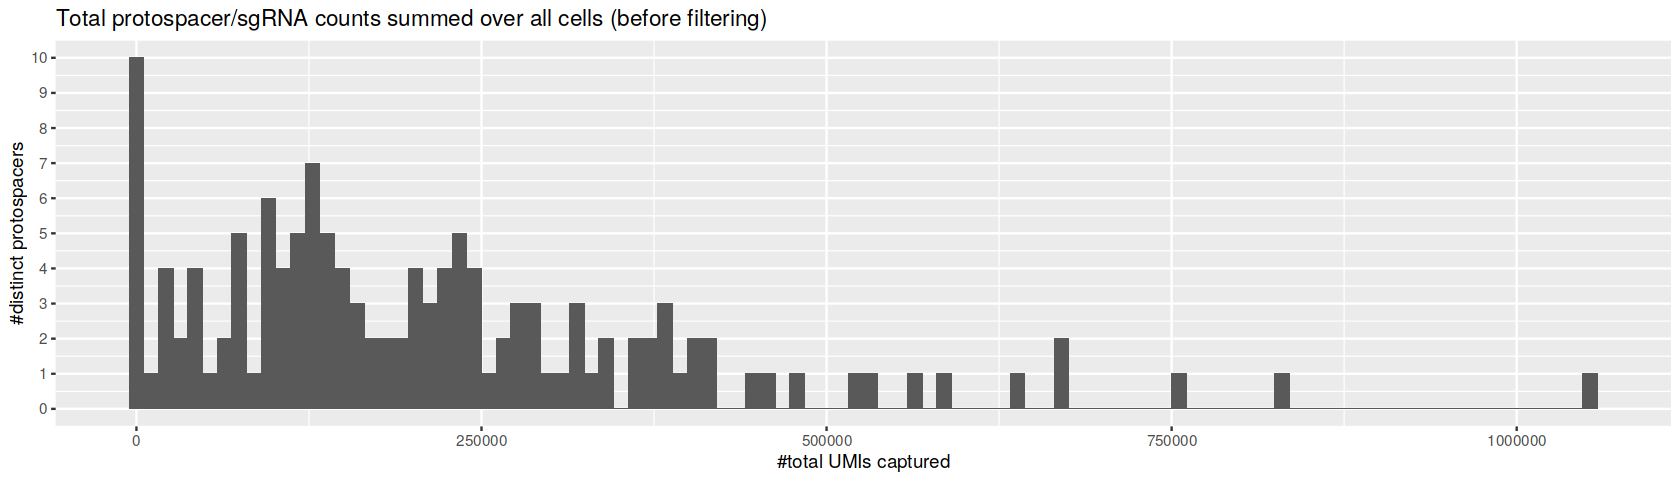

In [118]:
df_guide_counts = data.frame(total_guide_count=rowSums(sgrna_counts))
row.names(df_guide_counts) <- row.names(sgrna_counts)

options(repr.plot.width=14, repr.plot.height=4)
ggplot(df_guide_counts, aes(x = total_guide_count)) +
    geom_histogram(bins=100) +
    labs(title = "Total protospacer/sgRNA counts summed over all cells (before filtering)", x = "#total UMIs captured") +
    labs(y = "#distinct protospacers") +
    scale_y_continuous(breaks=seq(0,10, by=1))


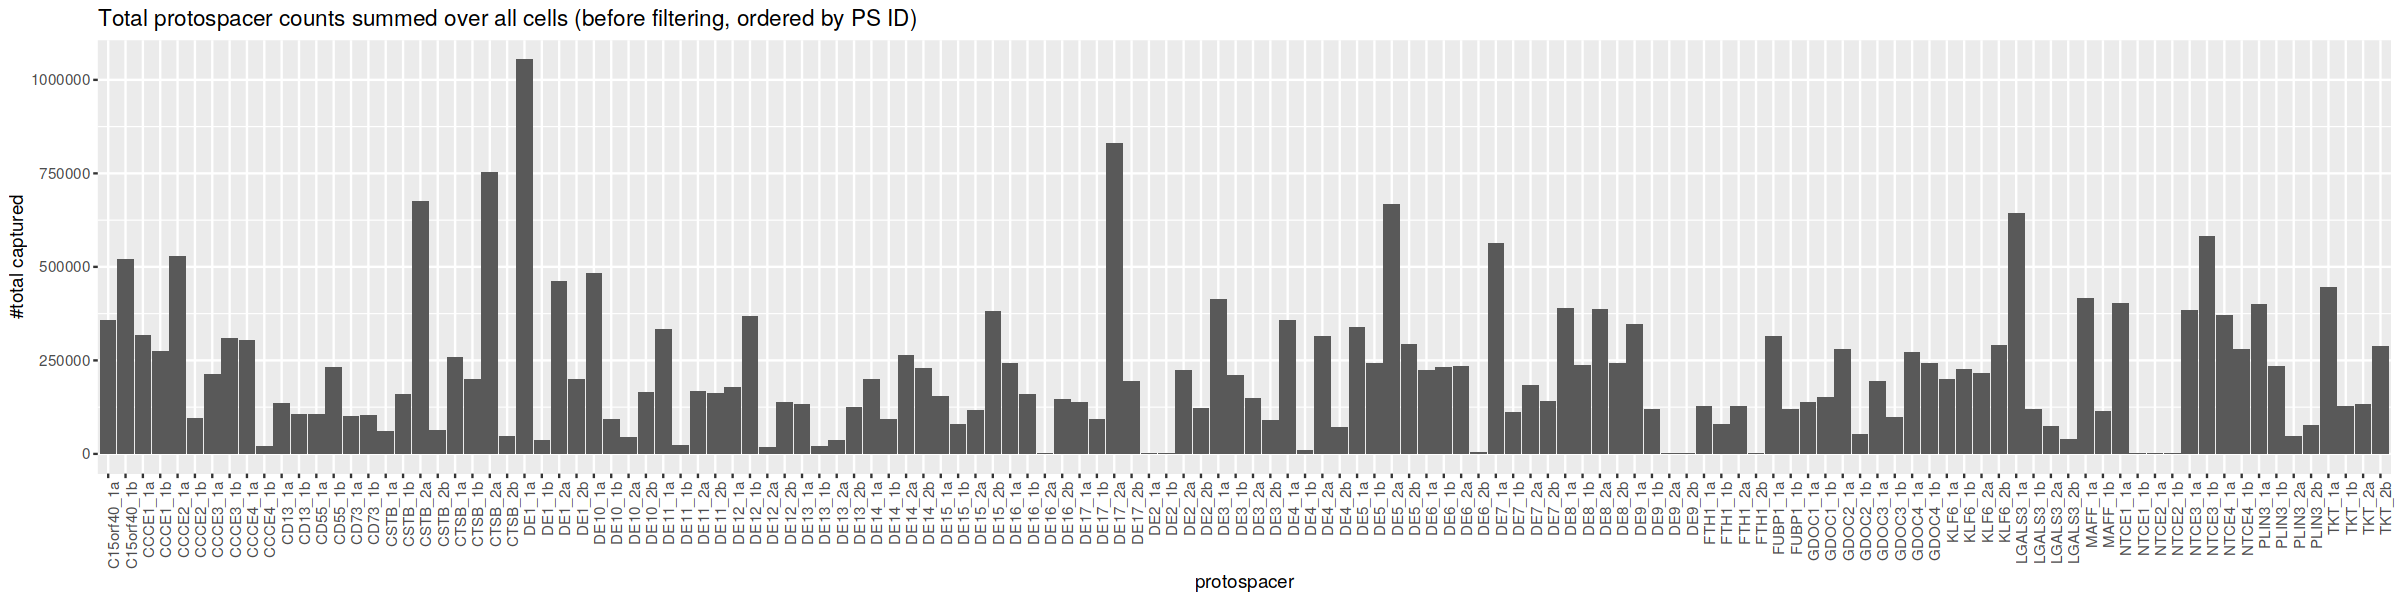

In [119]:
df_guide_counts_ordered <- df_guide_counts[order(df_guide_counts$total_guide_count),,drop=FALSE]
df_guide_counts_ordered$protospacer  <- rownames(df_guide_counts_ordered)

options(repr.plot.width=20, repr.plot.height=5)
ggplot(df_guide_counts_ordered, aes(x=protospacer, y=total_guide_count)) +
    geom_bar(stat='identity') + 
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(title = "Total protospacer counts summed over all cells (before filtering, ordered by PS ID)", x = "protospacer") +
    labs(y = "#total captured") 

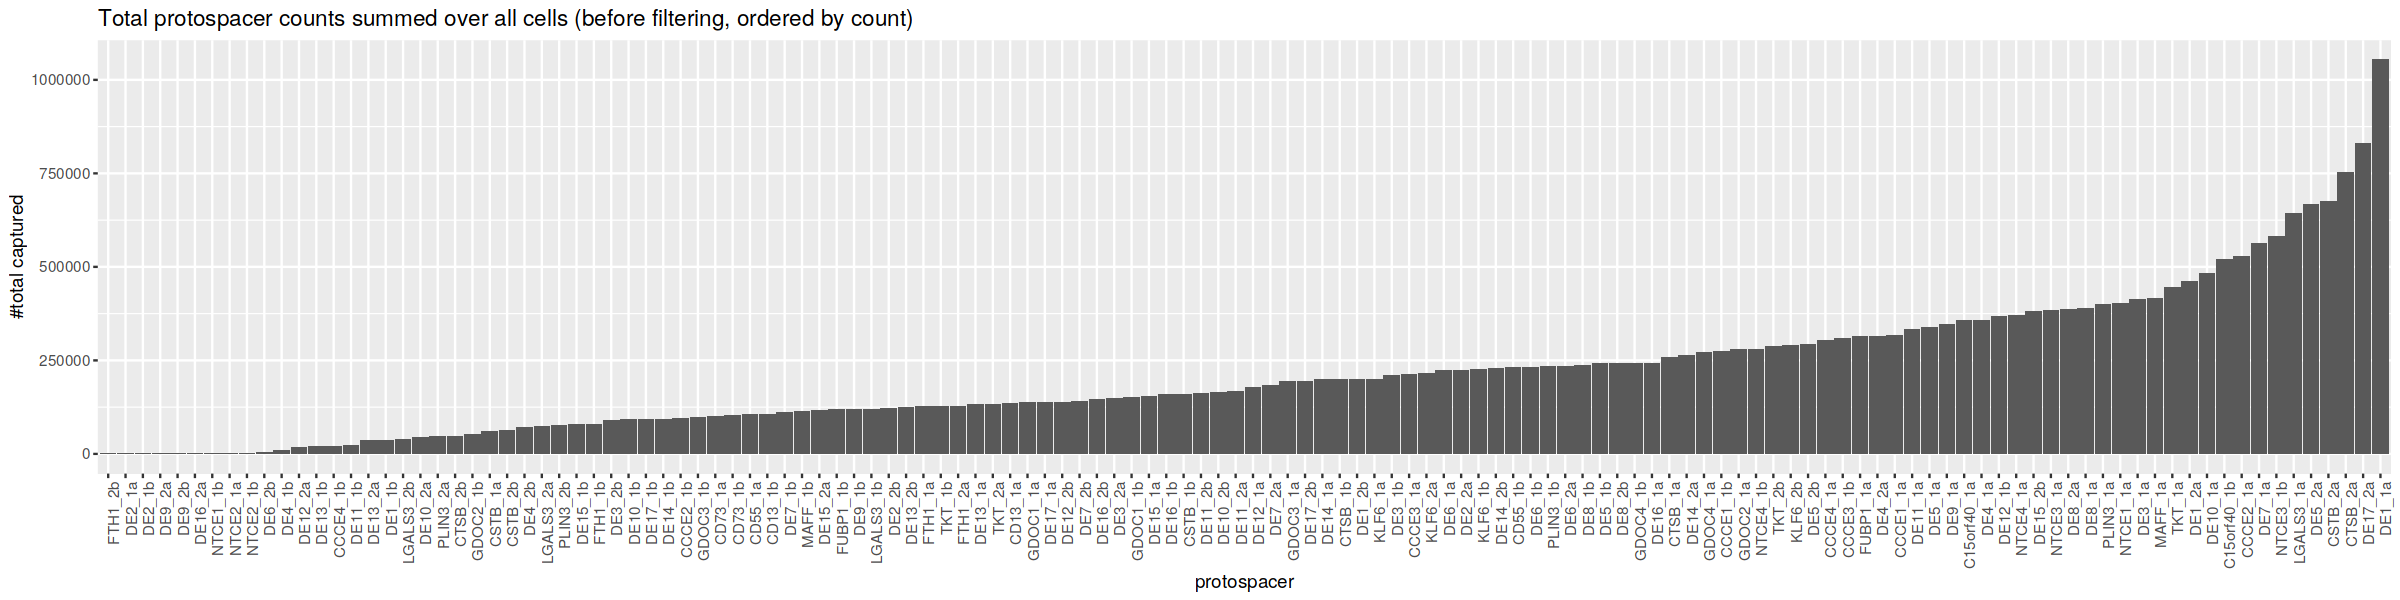

In [120]:
df_guide_counts_ordered$protospacer <- factor(df_guide_counts_ordered$protospacer, levels = df_guide_counts_ordered$protospacer)

options(repr.plot.width=20, repr.plot.height=5)
ggplot(df_guide_counts_ordered, aes(x=protospacer, y=total_guide_count)) +
    geom_bar(stat='identity') + 
    theme(axis.text.x = element_text(angle = 90, vjust = 1, hjust=1)) +
    labs(title = "Total protospacer counts summed over all cells (before filtering, ordered by count)", x = "protospacer") +
    labs(y = "#total captured") 

# Import Cellranger outputs into Seurat

In [121]:
seurat_unfiltered <- CreateSeuratObject(counts = rna_counts, project = prj_name)
sgrna_assay       <- CreateAssayObject(counts = sgrna_counts)
seurat_unfiltered[["sgRNA"]] <- sgrna_assay

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


### Get mitochondrial content

In [122]:
seurat_unfiltered[["percent.mt"]] <-
    PercentageFeatureSet(seurat_unfiltered, pattern = "^MT-")

In [123]:
DefaultAssay(seurat_unfiltered) <- "RNA"

## QC

### Get RNA counts per cell

In [124]:
counts_per_cell <- Matrix::colSums(rna_counts)
cat("counts per cell: ", counts_per_cell[1:20], "\n") ## counts for first 5 cells

counts per cell:  25177 126284 43882 72819 63548 34134 58713 39586 41292 34276 85917 24140 52964 60166 44031 90062 42192 9360 53193 60136 


In [125]:
counts_per_gene <- Matrix::rowSums(rna_counts)
cat("counts per gene: ", counts_per_gene[1:20], "\n")  

counts per gene:  3 0 4 157 9 0 223 3 0 2 0 1 0 3 2711 4 3178 148 465 115 


In [126]:
genes_per_cell  <- Matrix::colSums(rna_counts > 0)       # count gene only if it has non-zero reads mapped.
guides_per_cell <- Matrix::colSums(sgrna_counts > 0)     # count gene only if it has non-zero reads mapped.

cat("counts for non-zero genes: ", genes_per_cell[1:5], "\n")  # counts for first 5 genes
cat("counts for non-zero guides:", guides_per_cell[1:5], "\n")  # counts for first 5 genes

counts for non-zero genes:  5887 11066 7417 9098 8607 
counts for non-zero guides: 19 28 31 22 20 


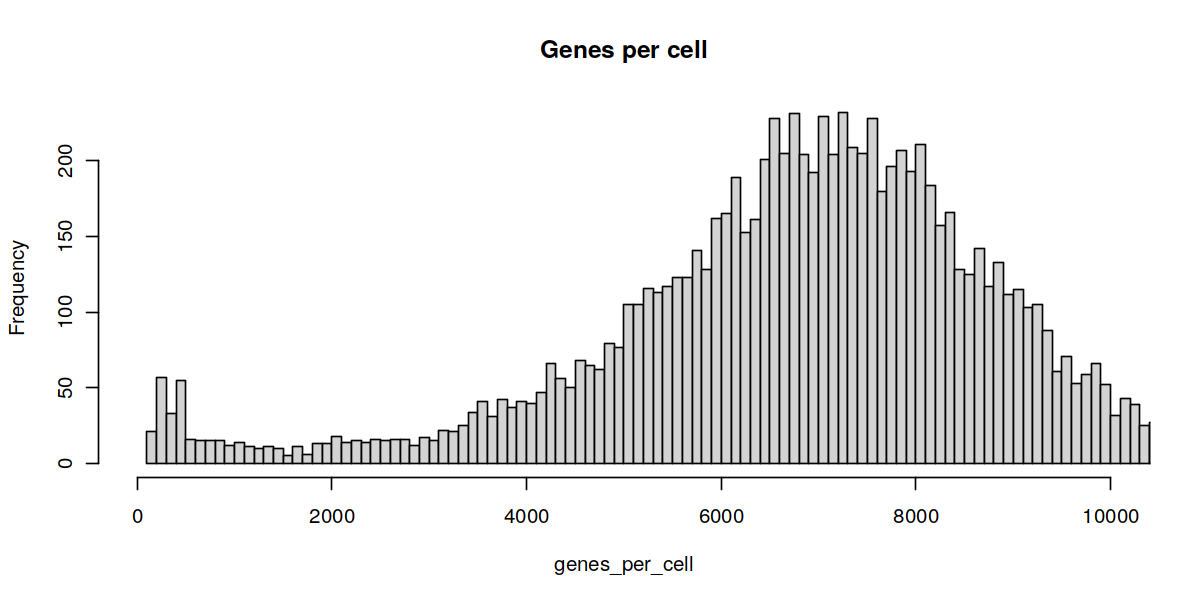

In [127]:
options(repr.plot.width=10, repr.plot.height=5)
#plot_log <- hist(log10(genes_per_cell), main="Genes per cell", breaks=100)
plot_lin <- hist(genes_per_cell, main="Genes per cell", breaks=100, xlim=c(1,10000))
#plot_guide_counts <- hist(guides_per_cell, main="Distinct protospacers per cell", breaks=100, xlim=c(1,100))

### --

### Plot RNA counts per cell 

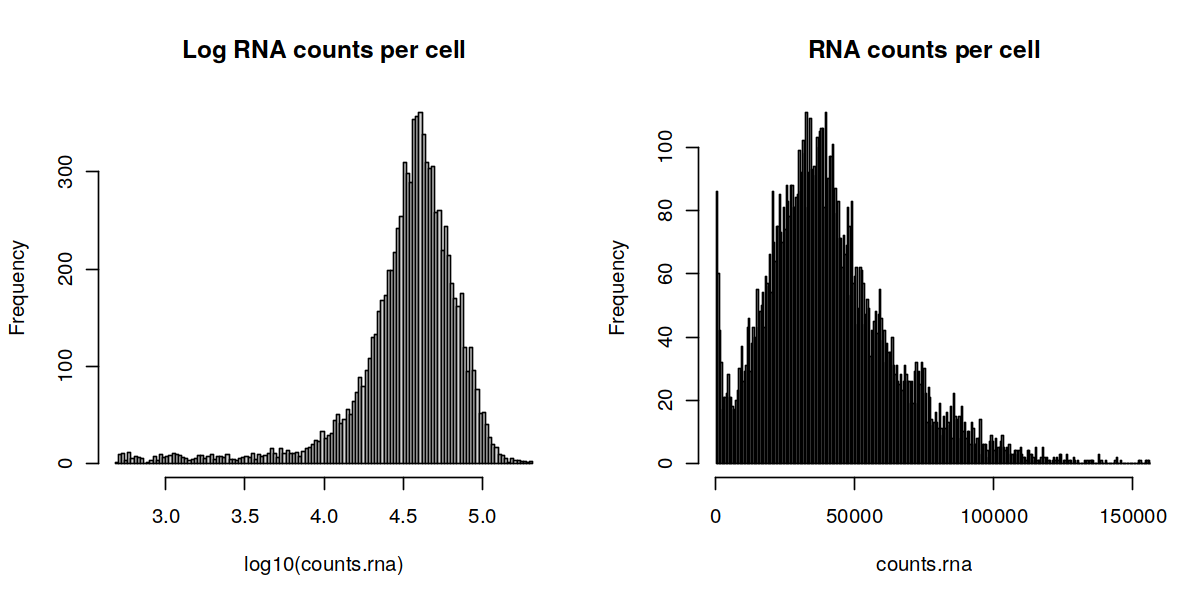

In [128]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
counts.rna <- seurat_unfiltered@meta.data$nCount_RNA
plot_log    <- hist(log10(counts.rna), main="Log RNA counts per cell", breaks=100)
plot_lin    <- hist(counts.rna, main="RNA counts per cell", breaks=500, xlim=c(1,150000))

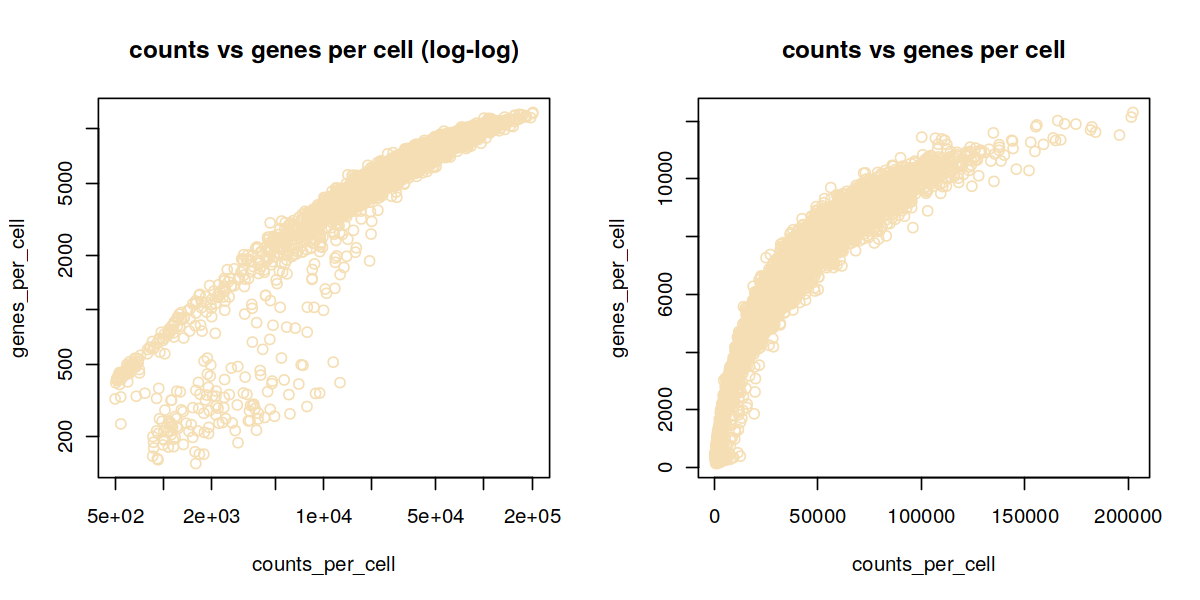

In [129]:
options(repr.plot.width=10, repr.plot.height=5)
par(mfrow=c(1,2))
plot(counts_per_cell, genes_per_cell, log='xy', col='wheat')
title('counts vs genes per cell (log-log)')
plot(counts_per_cell, genes_per_cell, col='wheat')
title('counts vs genes per cell')

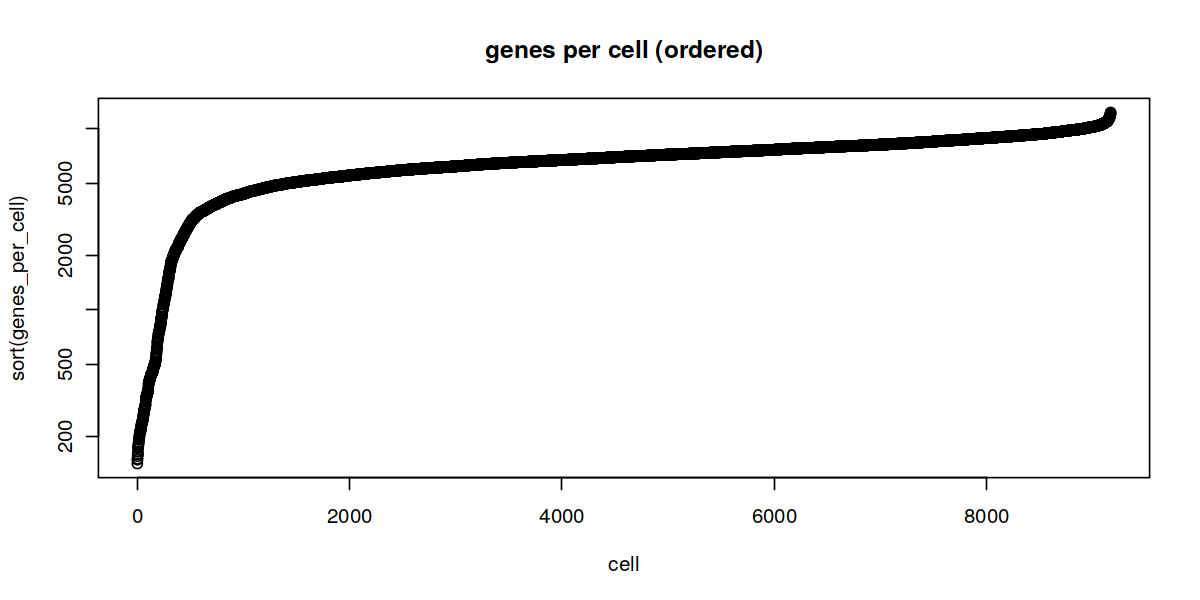

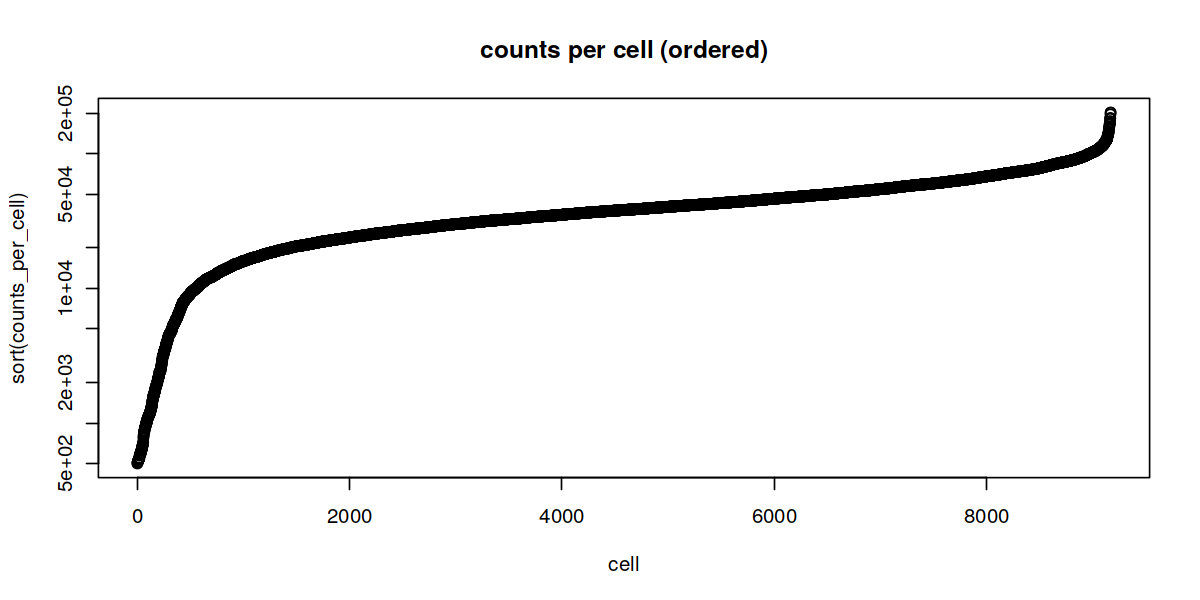

In [130]:
plot(sort(genes_per_cell), xlab='cell', log='y', main='genes per cell (ordered)')
plot(sort(counts_per_cell), xlab='cell', log='y', main='counts per cell (ordered)')

In [131]:
#FeatureScatter(object = seurat_unfiltered, feature1 = "nCount_RNA", feature2 = "nCount_ATAC", log)

### QC using houskeeping genes

In [132]:
# Load the the list of house keeping genes
hkgenes <- read.table("/home/vsevim/prj/tf/tf1/data/QC/housekeeping.txt", skip = 2)
hkgenes <- as.vector(hkgenes$V1)

In [133]:
# remove hkgenes that were not found
hkgenes.found <- which(toupper(rownames(seurat_unfiltered@assays$RNA@data)) %in% hkgenes)

In [134]:
num_hk_genes = length(hkgenes.found)
num_hk_genes

[1] 95

In [135]:
n.expressed.hkgenes <- Matrix::colSums(seurat_unfiltered@assays$RNA@data[hkgenes.found, ] > 0)

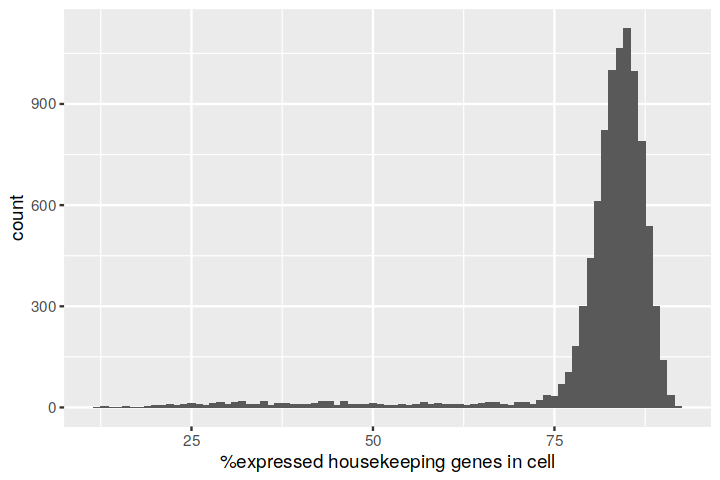

In [136]:
options(repr.plot.width=6, repr.plot.height=4)
df.expressed.hk <- data.frame(100*n.expressed.hkgenes/num_hk_genes)
ggplot(df.expressed.hk, aes(n.expressed.hkgenes)) + geom_histogram(binwidth=1) + labs(x="%expressed housekeeping genes in cell")

### QC by mitochondrial genes

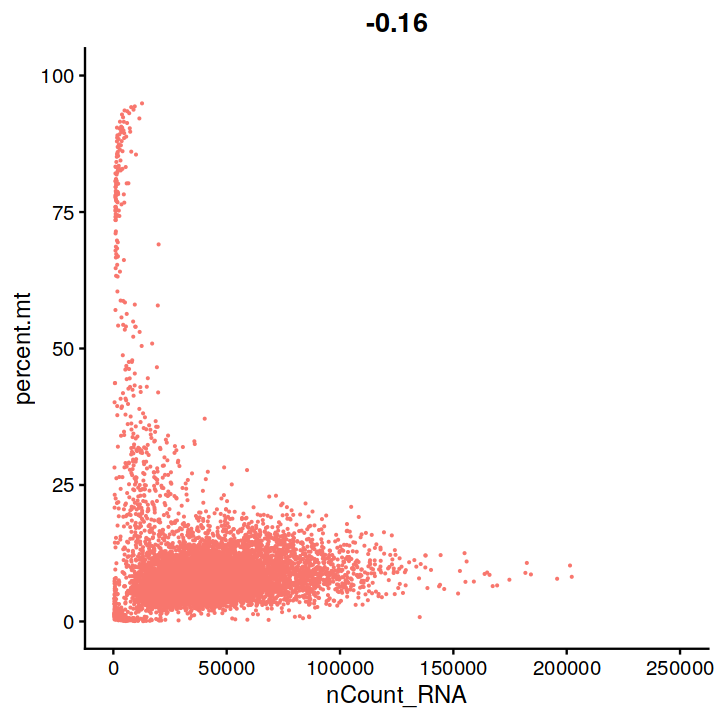

In [137]:
options(repr.plot.width=6, repr.plot.height=6)
plot1 <- FeatureScatter(seurat_unfiltered, feature1 = "nCount_RNA", feature2 = "percent.mt", pt.size=.1)
plot1 + xlim(c(0,250000)) + ylim(c(0,100)) + NoLegend()

## Filtering

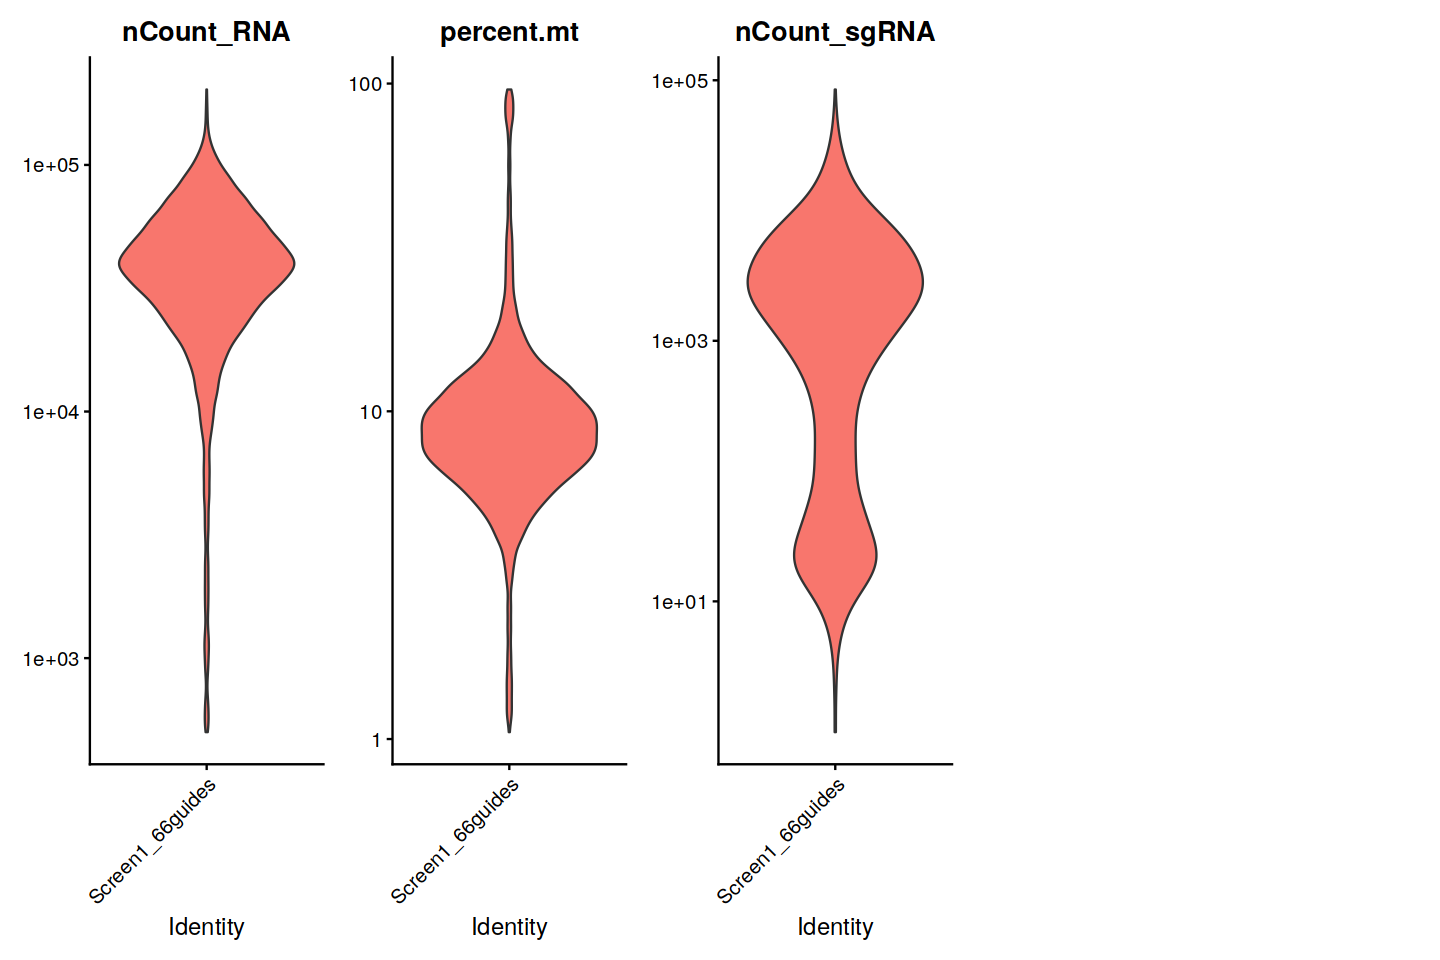

In [138]:
options(repr.plot.width=12, repr.plot.height=8)

VlnPlot(
  object = seurat_unfiltered,
  features = c("nCount_RNA", "percent.mt", "nCount_sgRNA"),
  ncol = 5,
  log=TRUE,
  pt.size = 0
)

### Filter out low quality cells

In [139]:
seurat <- subset(
  x = seurat_unfiltered,
  subset = nCount_RNA < 170000 &
    nCount_RNA > 6000 &
    percent.mt < 20 
)


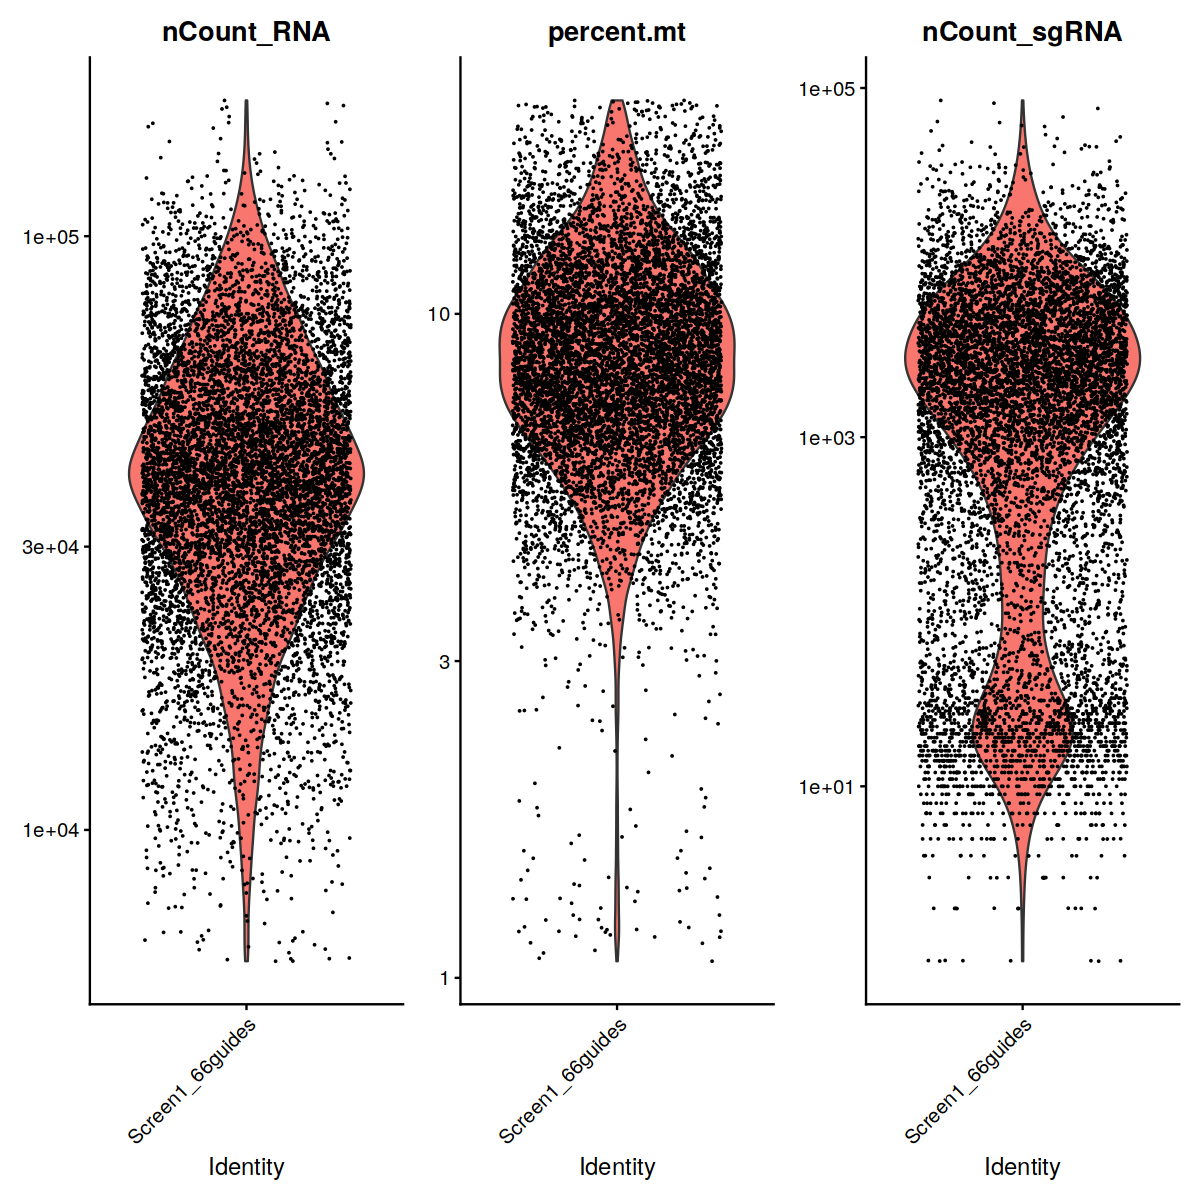

In [140]:
options(repr.plot.width=10, repr.plot.height=10)
VlnPlot(seurat, 
        features = c("nCount_RNA", "percent.mt", "nCount_sgRNA"), 
        ncol = 3, 
        log = TRUE, 
        pt.size = .01)

In [141]:
nrow(seurat@meta.data)

[1] 8550

## Normalization, PCA, UMAP, SVD

### Normalize RNA assay

In [142]:
DefaultAssay(seurat) <- "RNA"
seurat <- SCTransform(seurat, vst.flavor = "v2", verbose = FALSE) %>% 
          RunPCA() %>% 
          RunUMAP(dims = 1:40, reduction.name = 'umap.rna', reduction.key = 'rnaUMAP_', verbose=FALSE)

PC_ 1 
Positive:  KCNIP4, ERBB4, MECOM, FAM155A, AC019197.1, WFDC2, MAL, PDE1A, PKHD1, KITLG 
	   BST2, SFRP1, BICC1, SKAP1, PCSK5, ACSL4, CSGALNACT1, S100A2, SCN2A, KAZN 
	   SNED1, SPON1, HOXB3, EFNA5, KRT19, ITGA2, LRP1B, TFCP2L1, ARHGEF38, MIR31HG 
Negative:  FTL, CRYAB, MT1X, FTH1, APOE, SOD2, S100A1, MT1E, SERPINA1, PLIN2 
	   G0S2, FN1, MT2A, CTSB, MGST1, RARRES2, RRAD, NUPR1, SERPINE1, FGB 
	   GPX3, AKR1C3, SAA1, VGF, IL32, PDZK1IP1, ITPKA, VCAM1, SQSTM1, TFPI2 
PC_ 2 
Positive:  CENPF, MKI67, TUBA1B, TOP2A, HMGB2, ASPM, TPX2, DLGAP5, CCNB1, HMMR 
	   CEP55, ANLN, NUSAP1, PCLAF, TUBB4B, CKS2, PRC1, PBK, PTTG1, H2AFZ 
	   UBE2S, GTSE1, CDKN3, BIRC5, CDK1, RRM2, UBE2C, STMN1, CDC20, CENPE 
Negative:  MALAT1, NEAT1, AC079352.1, NRXN3, LINC01320, FKBP5, MDM2, SOD2, ZIM3, FNIP2 
	   PDE4D, PTCHD4, GPC6, CPD, GBE1, MAGI2, ADAMTS9-AS2, FHIT, AL138828.1, LRMDA 
	   KCNIP4, TRABD2B, PKP4, APOE, FGF14, ZNF385B, SERPINA1, FTX, ZFPM2-AS1, LRRK2 
PC_ 3 
Positive:  ERBB4, KCNIP4, WFDC2, MEC

### Normalize sgRNA counts

In [143]:
seurat <- NormalizeData(
    seurat,
    assay = "sgRNA",
    normalization.method = "CLR"
)

Normalizing across features



Save to Seurat H5

In [144]:
if(save_seurat_h5 == "YES") {
    SaveH5Seurat(seurat, filename=save_h5_file, overwrite=TRUE, verbose=FALSE)
}

In [145]:
head(seurat,5)

,orig.ident,nCount_RNA,nFeature_RNA,nCount_sgRNA,nFeature_sgRNA,percent.mt,nCount_SCT,nFeature_SCT
,<fct>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<int>
AAACCCAAGAGCAGCT-1,Screen1_66guides,25177,5887,3237,19,6.7,38362,5888
AAACCCAAGCCGGAAT-1,Screen1_66guides,126284,11066,5755,28,11.6,40275,7966
AAACCCAAGCTTAAGA-1,Screen1_66guides,43882,7417,2844,31,9.0,40596,7326
AAACCCAAGGCTGTAG-1,Screen1_66guides,72819,9098,1908,22,14.1,40339,7795
AAACCCAAGGTTTACC-1,Screen1_66guides,63548,8607,2088,20,6.2,40711,8159


#### Group PS counts by target genes

In [146]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL
#df_guide_counts$n_guides <- rowSums(df_guide_counts)
head(df_guide_counts,2)
ncol(df_guide_counts)


,CD13-1a,CD13-1b,CD55-1a,CD55-1b,CD73-1a,CD73-1b,FUBP1-1a,FUBP1-1b,C15orf40-1a,C15orf40-1b,⋯,GDOC4-1a,GDOC4-1b,CCCE1-1a,CCCE1-1b,CCCE2-1a,CCCE2-1b,CCCE3-1a,CCCE3-1b,CCCE4-1a,CCCE4-1b
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,941,0,3,0,⋯,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1570,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,746,76


[1] 132

In [147]:
ps_ids <- colnames(df_guide_counts)
ps_ids <- gsub("-1a", "", ps_ids)
ps_ids <- gsub("-1b", "", ps_ids)
ps_ids <- gsub("-2a", "", ps_ids)
ps_ids <- gsub("-2b", "", ps_ids)
ps_ids <- unique(ps_ids)

for (ps_id in ps_ids) {    
    df_guide_counts[, ps_id] <- rowSums(select(df_guide_counts, contains(ps_id)))
}

In [148]:
ps_ids

[1] "CD13"     "CD55"     "CD73"     "FUBP1"    "C15orf40" "MAFF"    
 [7] "FTH1"     "PLIN3"    "TKT"      "LGALS3"   "CSTB"     "CTSB"    
[13] "KLF6"     "DE1"      "DE2"      "DE3"      "DE4"      "DE5"     
[19] "DE6"      "DE7"      "DE8"      "DE9"      "DE10"     "DE11"    
[25] "DE12"     "DE13"     "DE14"     "DE15"     "DE16"     "DE17"    
[31] "NTCE1"    "NTCE2"    "NTCE3"    "NTCE4"    "GDOC1"    "GDOC2"   
[37] "GDOC3"    "GDOC4"    "CCCE1"    "CCCE2"    "CCCE3"    "CCCE4"

In [149]:
df_guides_by_target <- df_guide_counts[, ps_ids]
df_guides_by_target$total_targets <- rowSums(df_guides_by_target!=0)
head(df_guides_by_target)
ncol(df_guides_by_target)

,CD13,CD55,CD73,FUBP1,C15orf40,MAFF,FTH1,PLIN3,TKT,LGALS3,⋯,NTCE4,GDOC1,GDOC2,GDOC3,GDOC4,CCCE1,CCCE2,CCCE3,CCCE4,total_targets
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,941,3,1,0,0,0,0,⋯,0,0,0,0,0,1,0,0,1,16
2,0,1570,0,0,0,0,0,2479,0,1,⋯,0,3,0,2,1,0,0,0,822,23
3,1475,0,0,20,0,0,0,0,0,2,⋯,4,0,0,0,1,1,0,22,0,22
4,0,1,0,1,0,0,1,0,1887,0,⋯,1,0,0,0,1,0,1,0,0,18
5,2,0,1,1,0,0,0,0,1,0,⋯,0,0,0,0,1,1,0,0,0,19
6,0,0,0,0,0,0,0,1,1,0,⋯,0,0,0,0,0,0,0,0,0,7


[1] 43

#### Group PS counts by construct

In [150]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL

ps_ids <- colnames(df_guide_counts)
ps_ids <- gsub("-1a", "-1", ps_ids)
ps_ids <- gsub("-1b", "-1", ps_ids)
ps_ids <- gsub("-2a", "-2", ps_ids)
ps_ids <- gsub("-2b", "-2", ps_ids)
ps_ids <- unique(ps_ids)

for (ps_id in ps_ids) {    
    df_guide_counts[, ps_id] <- rowSums(select(df_guide_counts, contains(ps_id)))
}
ps_ids
length(ps_ids)

[1] "CD13-1"     "CD55-1"     "CD73-1"     "FUBP1-1"    "C15orf40-1"
 [6] "MAFF-1"     "FTH1-1"     "FTH1-2"     "PLIN3-1"    "PLIN3-2"   
[11] "TKT-1"      "TKT-2"      "LGALS3-1"   "LGALS3-2"   "CSTB-1"    
[16] "CSTB-2"     "CTSB-1"     "CTSB-2"     "KLF6-1"     "KLF6-2"    
[21] "DE1-1"      "DE1-2"      "DE2-1"      "DE2-2"      "DE3-1"     
[26] "DE3-2"      "DE4-1"      "DE4-2"      "DE5-1"      "DE5-2"     
[31] "DE6-1"      "DE6-2"      "DE7-1"      "DE7-2"      "DE8-1"     
[36] "DE8-2"      "DE9-1"      "DE9-2"      "DE10-1"     "DE10-2"    
[41] "DE11-1"     "DE11-2"     "DE12-1"     "DE12-2"     "DE13-1"    
[46] "DE13-2"     "DE14-1"     "DE14-2"     "DE15-1"     "DE15-2"    
[51] "DE16-1"     "DE16-2"     "DE17-1"     "DE17-2"     "NTCE1-1"   
[56] "NTCE2-1"    "NTCE3-1"    "NTCE4-1"    "GDOC1-1"    "GDOC2-1"   
[61] "GDOC3-1"    "GDOC4-1"    "CCCE1-1"    "CCCE2-1"    "CCCE3-1"   
[66] "CCCE4-1"

[1] 66

In [151]:
df_guides_by_vector <- df_guide_counts[, ps_ids]
df_guides_by_vector$total_vectors <- rowSums(df_guides_by_vector!=0)
head(df_guides_by_vector)
ncol(df_guides_by_vector)

,CD13-1,CD55-1,CD73-1,FUBP1-1,C15orf40-1,MAFF-1,FTH1-1,FTH1-2,PLIN3-1,PLIN3-2,⋯,NTCE4-1,GDOC1-1,GDOC2-1,GDOC3-1,GDOC4-1,CCCE1-1,CCCE2-1,CCCE3-1,CCCE4-1,total_vectors
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,941,3,1,0,0,0,0,⋯,0,0,0,0,0,1,0,0,1,18
2,0,1570,0,0,0,0,0,0,2479,0,⋯,0,3,0,2,1,0,0,0,822,25
3,1475,0,0,20,0,0,0,0,0,0,⋯,4,0,0,0,1,1,0,22,0,26
4,0,1,0,1,0,0,0,1,0,0,⋯,1,0,0,0,1,0,1,0,0,21
5,2,0,1,1,0,0,0,0,0,0,⋯,0,0,0,0,1,1,0,0,0,19
6,0,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,6


[1] 67

### Visualize guide count distribution before demux

Warning message:
"Transformation introduced infinite values in continuous x-axis"
Warning message:
"Removed 8 rows containing non-finite values (stat_bin)."


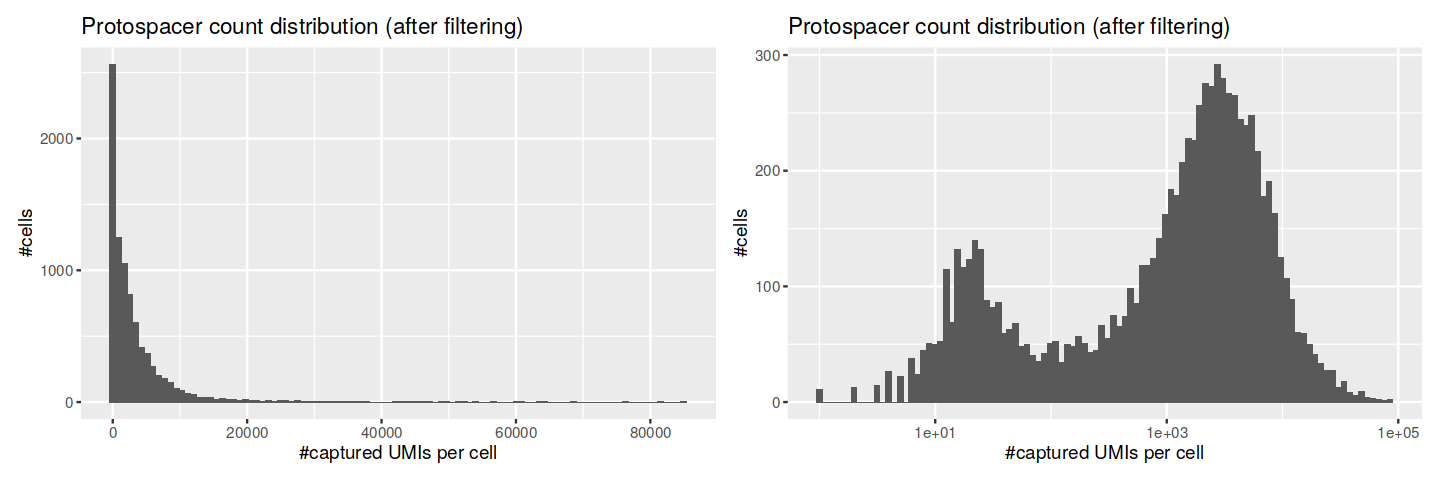

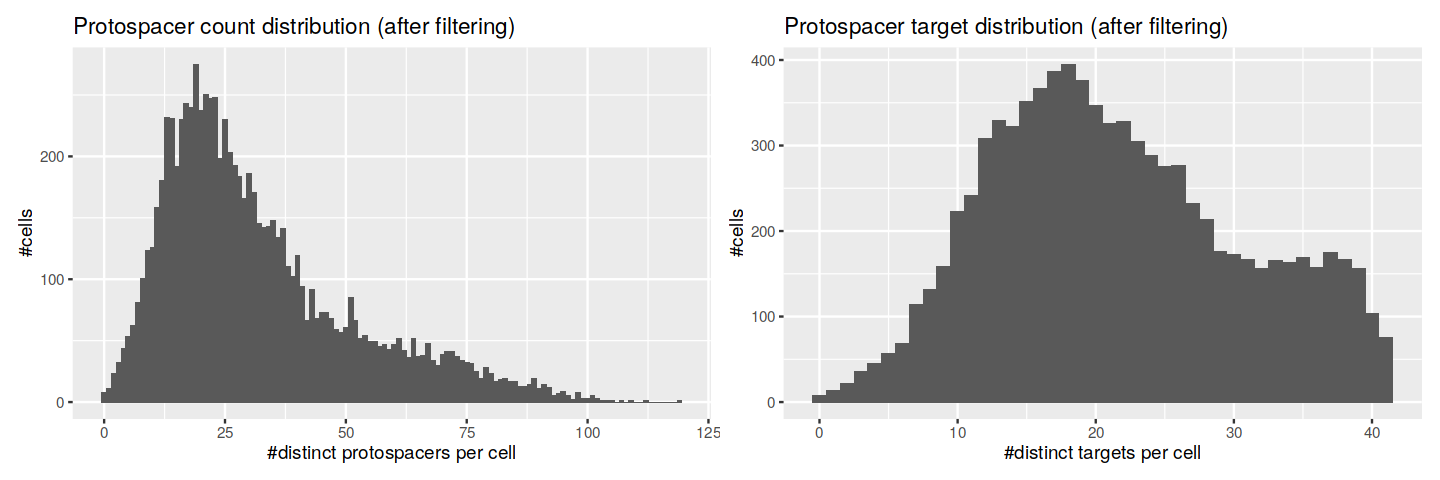

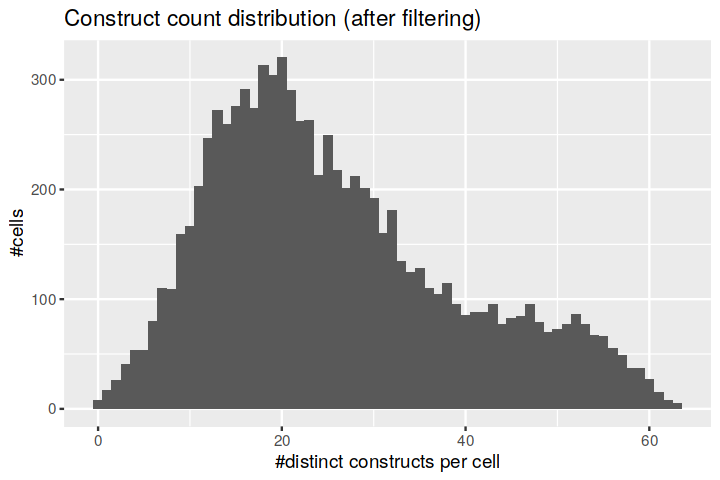

In [152]:
df_seurat <- seurat[[]]

p1 <- ggplot(df_seurat, aes(x = nCount_sgRNA)) +
    geom_histogram(bins=100) +
    labs(title = "Protospacer count distribution (after filtering)", x = "#captured UMIs per cell") +
    labs(y = "#cells") 

p2 <- ggplot(df_seurat, aes(x = nFeature_sgRNA)) +
    geom_histogram(binwidth=1) +
    labs(title = "Protospacer count distribution (after filtering)", x = "#distinct protospacers per cell") +
    labs(y = "#cells") 

p3 <- ggplot(df_guides_by_target, aes(x = total_targets)) +
    geom_histogram(binwidth=1) +
    labs(title = "Protospacer target distribution (after filtering)", x = "#distinct targets per cell") +
    labs(y = "#cells") 


p4 <- ggplot(df_guides_by_vector, aes(x = total_vectors)) +
    geom_histogram(binwidth=1) +
    labs(title = "Construct count distribution (after filtering)", x = "#distinct constructs per cell") +
    labs(y = "#cells") 

options(repr.plot.width=12, repr.plot.height=4)
p1 | p1 + scale_x_log10()
p2 | p3
options(repr.plot.width=6, repr.plot.height=4)
p4

### Visualize guide count distribution before demux

In [153]:
DefaultAssay(seurat) <- "sgRNA"
df_guide_counts <- as.data.frame(t(seurat[['sgRNA']]@counts))
rownames(df_guide_counts) <- NULL
df_guide_counts$n_guides <- rowSums(df_guide_counts)

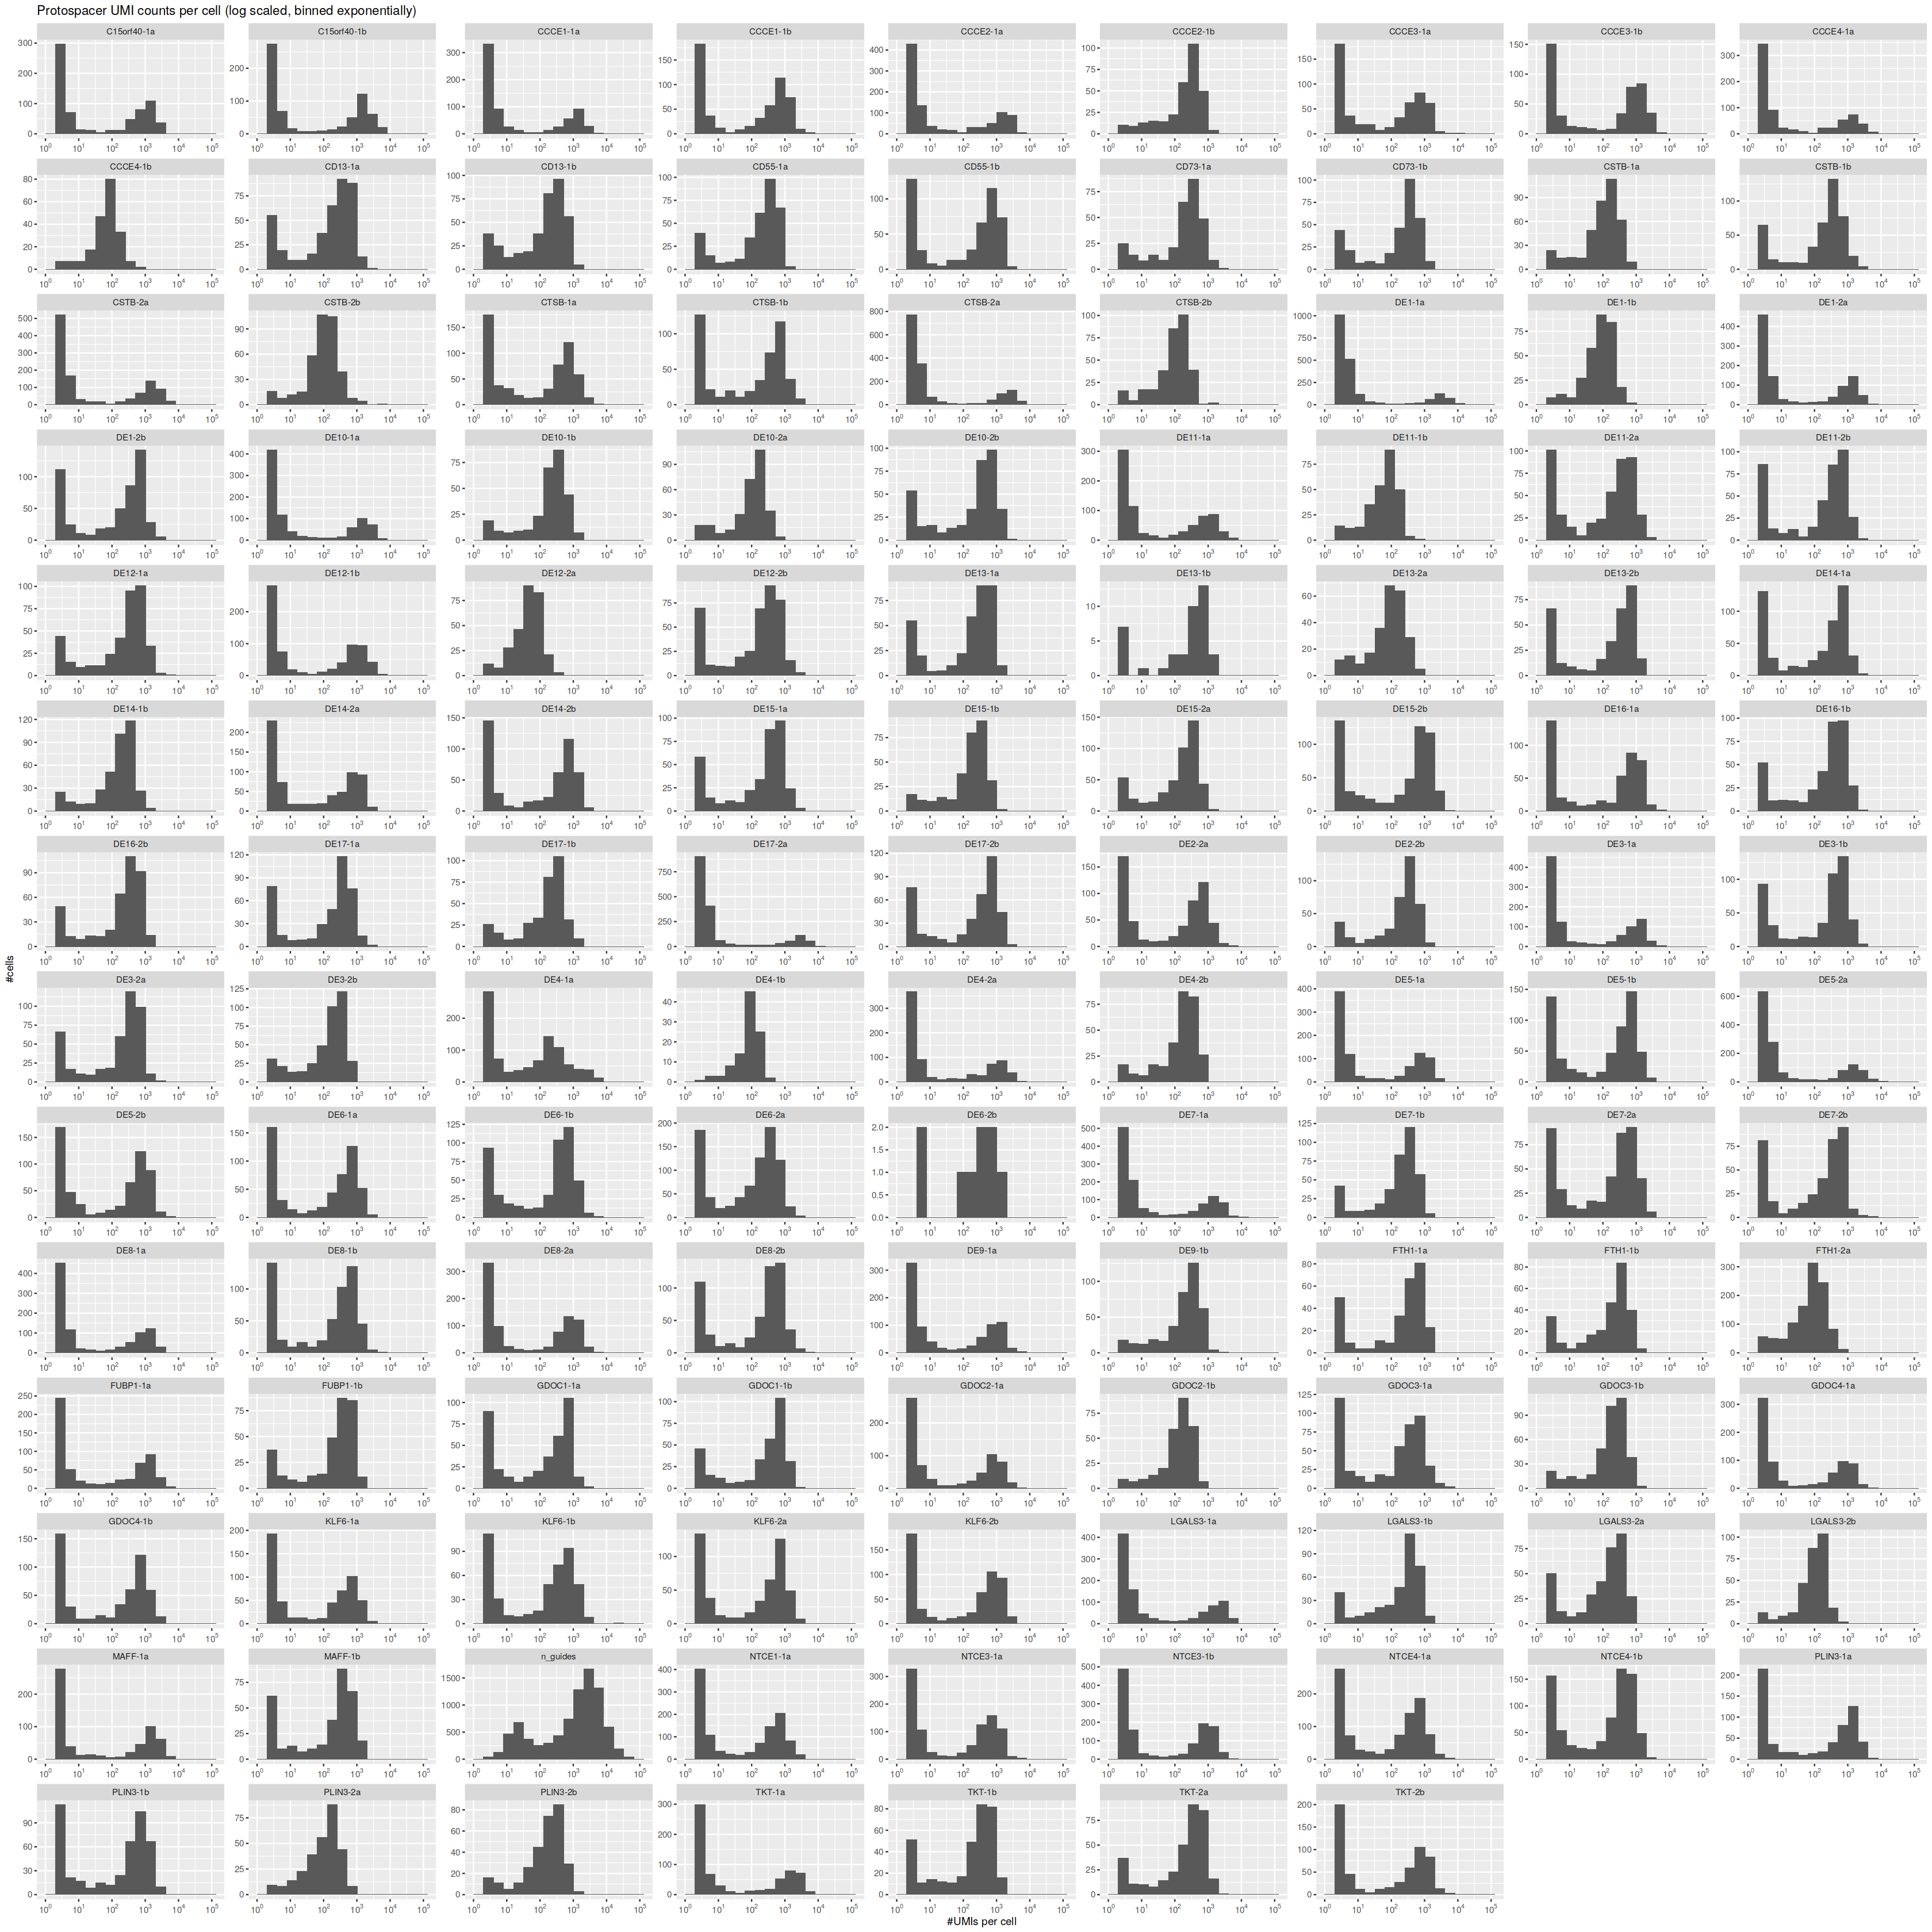

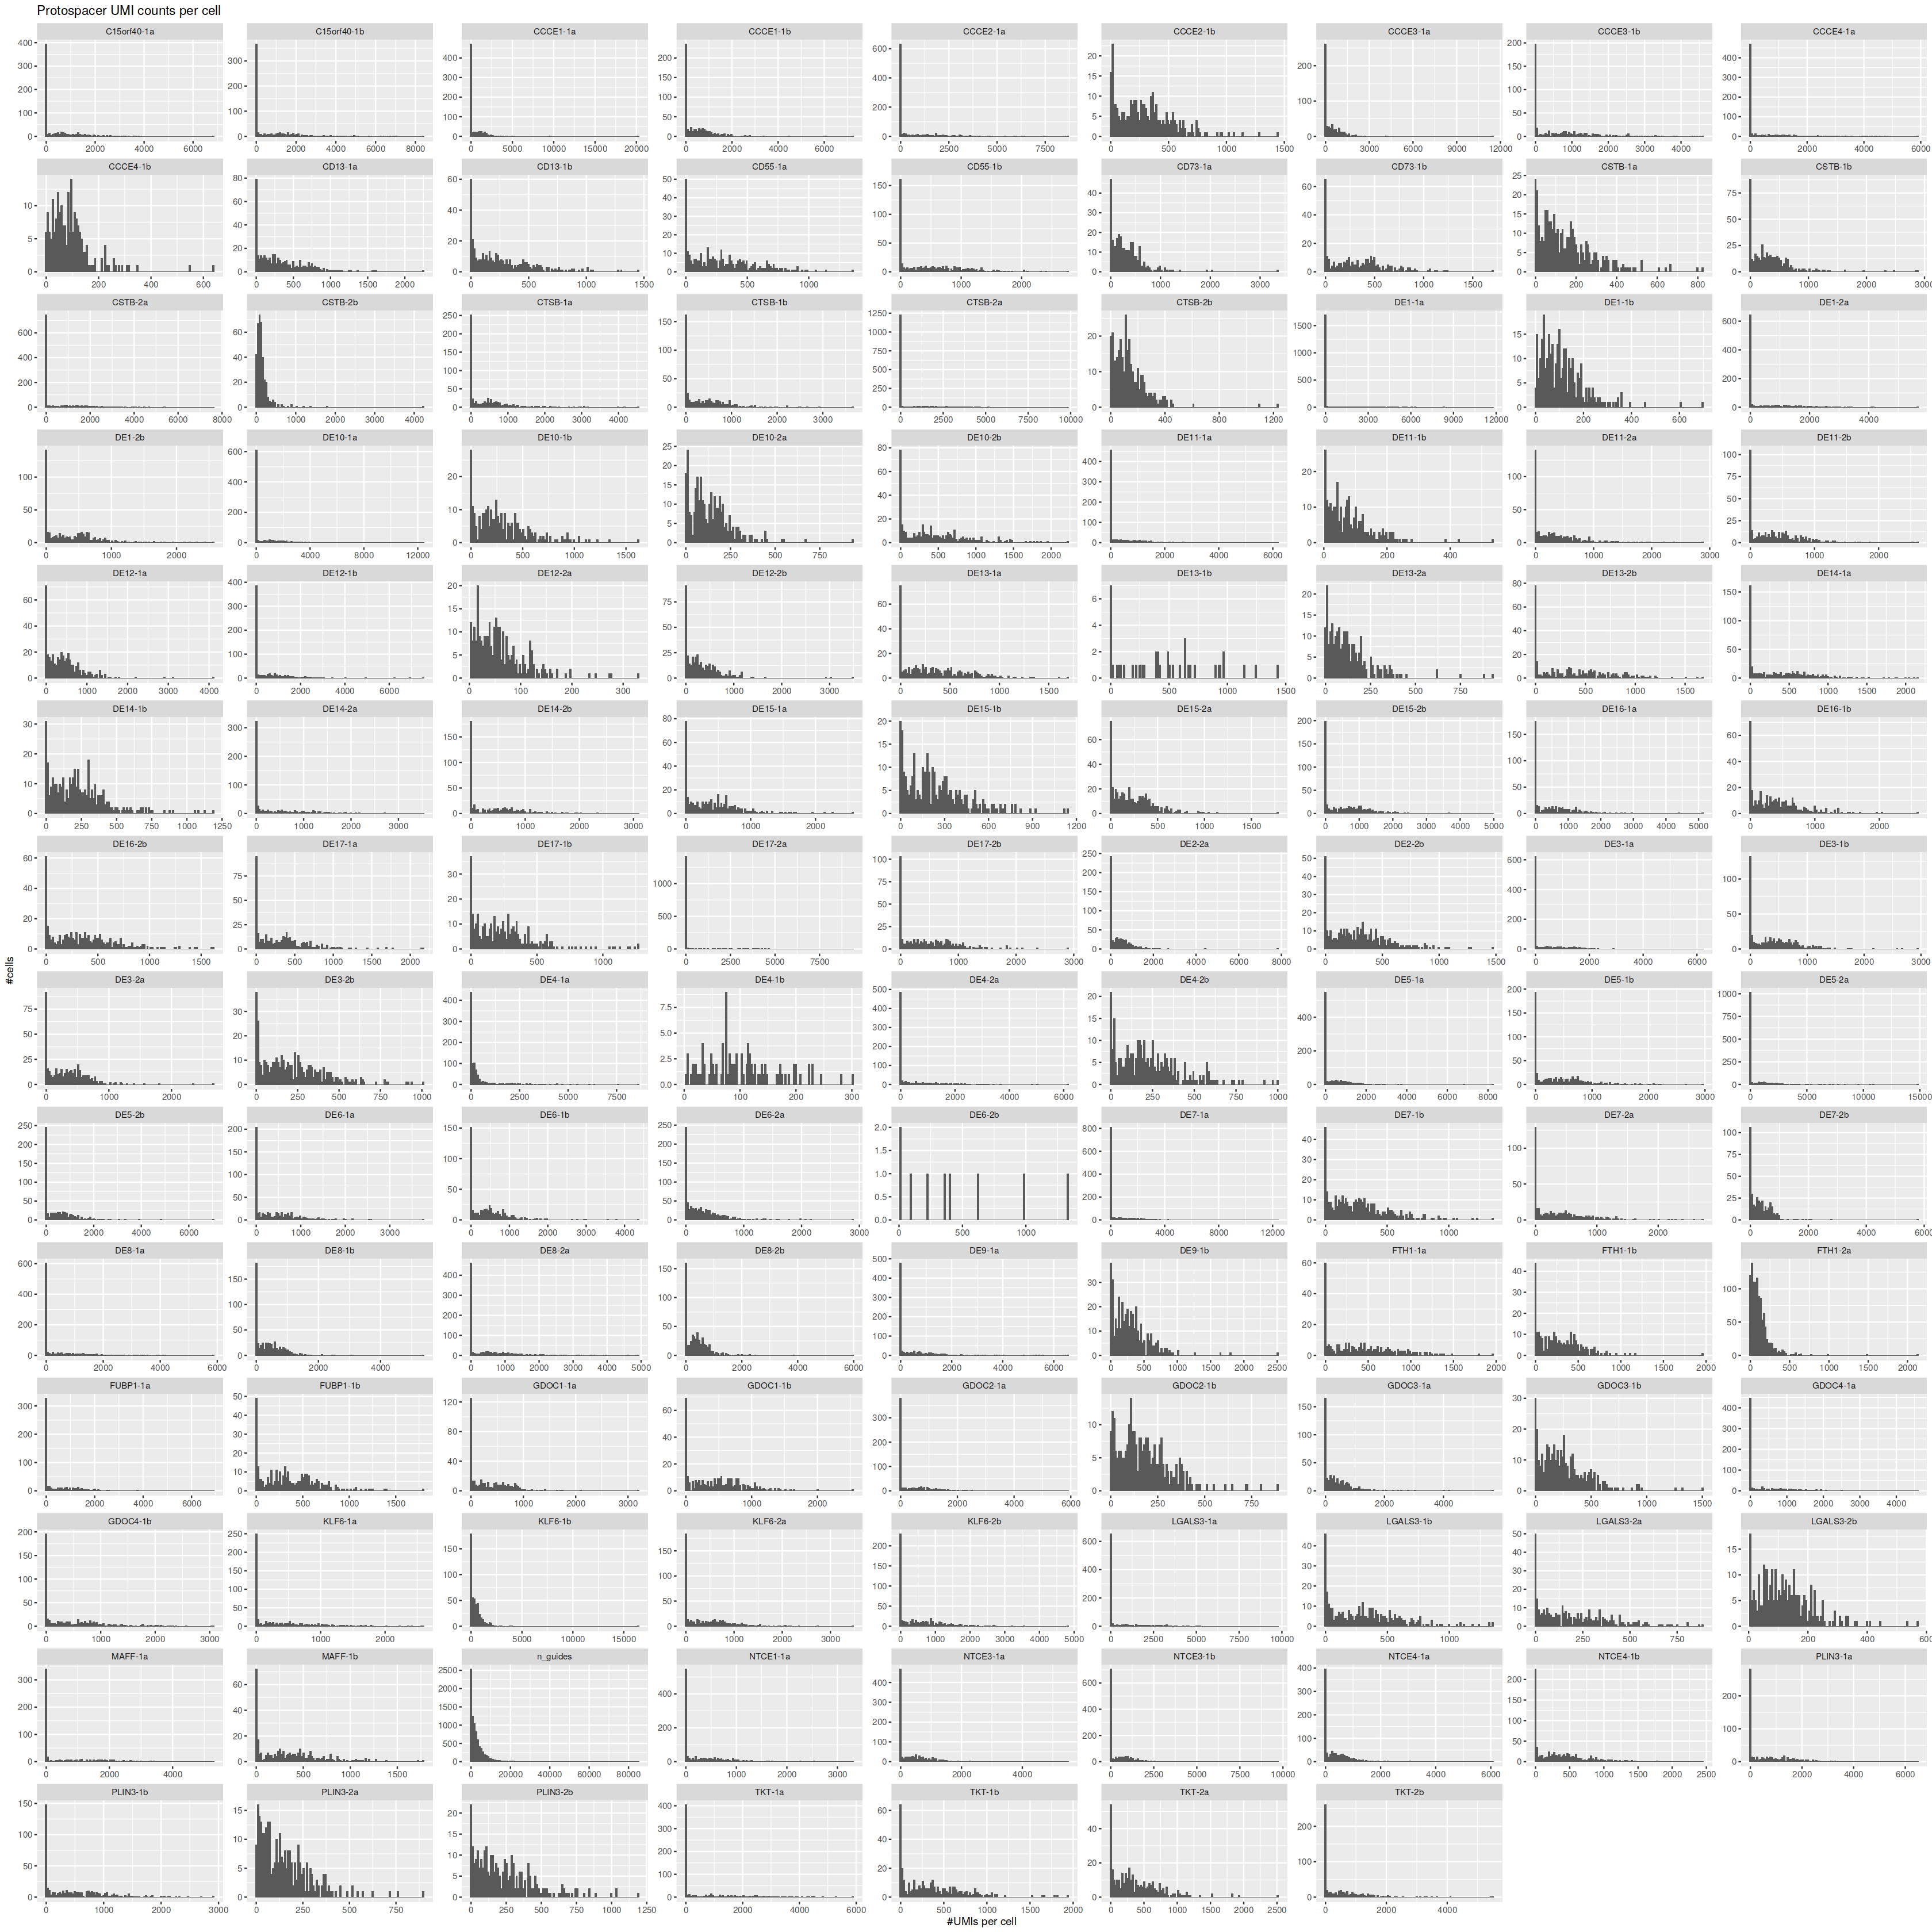

In [155]:
options(repr.plot.width=28, repr.plot.height=28)

data_long <- df_guide_counts %>%                    
  pivot_longer(colnames(df_guide_counts)) %>% 
  as.data.frame()

filter_zeros = data_long$value > 2
data_long <- data_long[filter_zeros,]
bin_breaks <- c(1,2,2*2^(1:16))

ggp1 <- ggplot(data_long, aes(x = value)) +    # Draw each column as histogram
  geom_histogram(breaks=bin_breaks) + 
  scale_x_log10(labels=trans_format('log10',math_format(10^.x)), breaks=c(1,10,100,1000,10000,100000)) +
  labs(title="Protospacer UMI counts per cell (log scaled, binned exponentially)", x="#UMIs per cell", y="#cells") +
  facet_wrap(~ name, scales = "free", ncol = 9)

ggp2 <- ggplot(data_long, aes(x = value)) +    # Draw each column as histogram
  geom_histogram(bins=100) + 
  labs(title="Protospacer UMI counts per cell", x="#UMIs per cell", y="#cells") +
  facet_wrap(~ name, scales = "free", ncol = 9)

ggp1
ggp2

# Demux using Cellranger

In [163]:
df_thresholds = read.csv(umi_thresholds_path)
df_ps_calls   = read.csv(ps_calls_path)

In [236]:
construct_calls = list()
num_construct_calls = list()

for(call in df_ps_calls$feature_call) {
    calls <- strsplit(call, "\\|")[[1]]
    guide_calls <- calls
    
    calls <- gsub("_1.", "-1", calls)
    calls <- gsub("_2.", "-2", calls)
    calls <- unique(calls)
    construct_calls     <- c(construct_calls, list(calls))
    num_construct_calls <- c(num_construct_calls, length(construct_calls))
}



In [238]:
head(df_ps_calls)

,cell_barcode,num_features,feature_call,num_umis
,<chr>,<int>,<chr>,<chr>
1,AGCTCAATCGTAGGGA-1,1,C15orf40_1a,57
2,CAACAGTTCCTAGCGG-1,1,C15orf40_1a,1383
3,AAACGCTCAGTTAGAA-1,2,C15orf40_1a|C15orf40_1b,1302|1753
4,AAAGGATAGCGATTCT-1,2,C15orf40_1a|C15orf40_1b,428|1565
5,ATCGGCGGTCTAGATC-1,2,C15orf40_1a|C15orf40_1b,1515|3322
6,ATTCCCGCATCCGCGA-1,2,C15orf40_1a|C15orf40_1b,606|1592
